In [ ]:
!pip install vit-keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=3220527259339b17506ec5d6958c71d33c5e4cd9540cb52171bfee46ce0e8680
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built validators


In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 23.8 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/MyDrive/manufacturing_bigdata/05.project01/02.outlier_classifier/outlier_train.zip" -d "/content/train"

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import imgaug.augmenters as iaa
import imgaug as ia
import pandas as pd
import cv2
from tensorflow.keras.utils import to_categorical
from vit_keras import vit, utils
from tensorflow.keras.utils import plot_model

In [ ]:
img_path = '/content/train/train/'
data_path = '/content/drive/MyDrive/ViT/data/'

#numpy 배열 출력시 가로로 길게 출력 되도록 설정
np.set_printoptions(linewidth=100000)

num_classes = 88
df = pd.read_csv("/content/drive/MyDrive/manufacturing_bigdata/05.project01/02.outlier_classifier/train_df.csv", index_col = 'index')
df

,file_name,class,state,label
index,,,,
0,10000.png,transistor,good,transistor-good
1,10001.png,capsule,good,capsule-good
2,10002.png,transistor,good,transistor-good
3,10003.png,wood,good,wood-good
4,10004.png,bottle,good,bottle-good
...,...,...,...,...
4272,14272.png,transistor,good,transistor-good
4273,14273.png,transistor,good,transistor-good
4274,14274.png,grid,good,grid-good


In [ ]:
# label-status의 88개 레이블을 index로 만들어 저장
df['label_int'] = df['label']
label_list = sorted(df['label'].unique())
for index, label in enumerate(label_list):
    df["label_int"].replace(label, index, inplace=True)

In [ ]:
df

,file_name,class,state,label,label_int
index,,,,,
0,10000.png,transistor,good,transistor-good,72
1,10001.png,capsule,good,capsule-good,15
2,10002.png,transistor,good,transistor-good,72
3,10003.png,wood,good,wood-good,76
4,10004.png,bottle,good,bottle-good,3
...,...,...,...,...,...
4272,14272.png,transistor,good,transistor-good,72
4273,14273.png,transistor,good,transistor-good,72
4274,14274.png,grid,good,grid-good,28


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:

#학습데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
                                     df["file_name"].tolist(),#이미지 파일의 이름
                                     df["label_int"].tolist(), #이미지 파일의 레이블
                                     test_size=0.1, #전체 데이터 중 10%를 테스트 데이터 사용
                                     stratify = df["label_int"],#label_int 컬럼의 비율 대로 분리
                                     random_state=157 #다음에도 같은 데이터로 분리하도록 설정
                                     )

In [ ]:
IM_HEIGHT = 224
IM_WIDTH = 224

In [ ]:
batch_size = 20

#이미지 증강 객체 선언

In [ ]:
ia.seed(1)

In [ ]:
#학습 이미지 증강 객체
train_seq = iaa.Sequential([
    iaa.Resize({"height": IM_HEIGHT, "width": IM_WIDTH}),
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        # Blur each image with varying strength using
        # gaussian blur (sigma between 0 and 3.0),
        # average/uniform blur (kernel size between 2x2 and 7x7)
        # median blur (kernel size between 3x3 and 11x11).
        iaa.OneOf([
            iaa.GaussianBlur((0, 3.0)),
            iaa.AverageBlur(k=(2, 7)),
            iaa.MedianBlur(k=(3, 11)),
            ]),
    ),
    iaa.Sometimes(
        0.3,
        #Either drop randomly 1 to 10% of all pixels (i.e. set
        # them to black) or drop them on an image with 2-5% percent
        # of the original size, leading to large dropped
        # rectangles.
        iaa.OneOf([
            iaa.Dropout((0.01, 0.1), per_channel=0.5),
            iaa.CoarseDropout(
                (0.03, 0.15), size_percent=(0.02, 0.05),
                per_channel=0.2
            ),
        ]),
    ),
    # crop some of the images by 0-10% of their height/width
    iaa.Sometimes(0.3 ,iaa.Crop(percent=(0, 0.1))),
    
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
        , mode=ia.ALL
        #, cval=(0, 255)
        ,cval=(255)
    )
], random_order=True) # apply augmenters in random order


In [ ]:
#테스트 이미지는 이미지 크기만 수정하고 다른 증강은 하지 않음
test_seq = iaa.Sequential([
    iaa.Resize({"height": IM_HEIGHT, "width": IM_WIDTH})
], random_order=True) # apply augmenters in random order

In [ ]:
import math

In [ ]:
#label의 종류를 저장
INPUT_DIM = len(label_list)

In [ ]:
INPUT_DIM 

88

In [ ]:
image_size = 224

In [ ]:
# 이미지를 증강시켜서 배치 사이즈 만큼씩 리턴하는 클래스 구현

class  ImageSequence(tf.keras.utils.Sequence):
    # 객체 생성시 실행되는 함수
    # 매개변수
    # image_arr : 이미지가 저장된 배열
    # label_arr : 이미지의 종류가 저장된 배열
    # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
    # seq : 이미지 증강 객체

    def __init__(self, file_name_list ,label_int_list, batch_size, seq, img_path, total):
        # 매개변수들을 속성에 저장
        self.file_name_list  = file_name_list 
        self.label_int_list = label_int_list
        self.batch_size = batch_size
        self.seq = seq
        self.img_path = img_path
        self.total = total
    
    # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
    def __len__(self):
        
        # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

        # total 이미지의 개수 / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
        return math.ceil(self.total / self.batch_size)

    # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
    # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
    def __getitem__(self, idx):
        #리턴할 이미지를 저장할 리스트
        batch_img = []
        #리턴할 레이블을 저장할 리스트
        batch_label = []
        #idx에 저장된 몆번째 batch인지 저장된 숫자에 batch_size 곱함
        start_index = int(idx * self.batch_size)
        #idx에 저장된 몆번째 batch인지 저장된 숫자 + 1 에 batch_size 곱함
        end_index = int((idx +1)*self.batch_size )
        image_size = 224
        #start_index 부터 end_index 까지 반복
        for index in range(start_index , end_index):
            #print("index = ", index)
            
            if index < self.total :
                #이미지 파일명 저장            
                file_name = self.file_name_list[index]
                
                #이미지를 읽어서 img에 저장
                img = cv2.imread(self.img_path + file_name)
                #print("file_path = ",(self.img_path + file_name) )
                
                #print("img=", img)
                #이미지를 읽지 못했다면
                if img is None:
                    #다음 이미지로 넘어감
                    continue
                #이미지의 색상을 RGB 타입으로 변경
                img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
                #이미지를 batch_img에 추가
                batch_img.append(img)
                #이미지 레이블을 batch_label에 추가
                batch_label.append(self.label_int_list[index])
                
        generate_img = None
        # batch_img를 증강시켜서 generate_img에 저장
        generate_img = self.seq(images=batch_img)
        #이미지를 float32타입으로 변환하고 255로 나눠줌        
        #generate_img = np.array(generate_img, dtype="float32") /255.0
        generate_img = np.array(generate_img)
        #print("generate_img =", generate_img)
        generate_img = vit.preprocess_inputs(generate_img)
        #print("generate_img = ", generate_img)
        #generate_img = generate_img.reshape(generate_img.shape[0],IM_HEIGHT, IM_WIDTH, 3)
        #INPUT_DIM (입력 레이블의 종류 88)
        # batch_label을 one hot encoding 함
        batch_label_arr = np.eye(INPUT_DIM)[ batch_label]
        # #batch_label_arr을 float32 타입 변환
        batch_label_arr = np.array(batch_label_arr, dtype="float32")
        
        #이미지와 레이블 리턴
        return generate_img,batch_label_arr
        

In [ ]:
# import tensorflow_addons as tfa

# # List of augmentation functions
# aug_func_list = [
#     # x90 positions of orig image
#     lambda image: image,
#     lambda image: tfa.image.rotate(image, math.pi/180*90),
#     lambda image: tfa.image.rotate(image, math.pi/180*180),
#     lambda image: tfa.image.rotate(image, math.pi/180*270),
#     # x90 positions of flipped-left-right image
#     lambda image: tf.image.flip_left_right(image),
#     lambda image: tf.image.transpose(image),
#     lambda image: tf.image.flip_up_down(image),
#     lambda image: tfa.image.rotate(tf.image.flip_up_down(image), math.pi/180*90),
#     # x45 positions of orig image without central crop, fill const 0 (black)
#     lambda image: tfa.image.rotate(image, math.pi/180*45 ),
#     lambda image: tfa.image.rotate(image, math.pi/180*135),
#     lambda image: tfa.image.rotate(image, math.pi/180*225),
#     lambda image: tfa.image.rotate(image, math.pi/180*315),
# ]

In [ ]:
# # 이미지를 증강시켜서 배치 사이즈 만큼씩 리턴하는 클래스 구현

# class  ImageSequence(tf.keras.utils.Sequence):
#     # 객체 생성시 실행되는 함수
#     # 매개변수
#     # image_arr : 이미지가 저장된 배열
#     # label_arr : 이미지의 종류가 저장된 배열
#     # batch_size : 배치 사이즈 (한번에 리턴할 파일 개수)
#     # seq : 이미지 증강 객체

#     def __init__(self, file_name_list ,label_int_list, batch_size, seq, img_path, total, istrain=1):
#         # 매개변수들을 속성에 저장
#         self.file_name_list  = file_name_list 
#         self.label_int_list = label_int_list
#         self.batch_size = batch_size
#         self.seq = seq
#         self.img_path = img_path
#         self.total = total
#         self.istrain = istrain
    
#     # batch_size씩 이미지를 리턴했을때 전체 이미지를 리턴하려명 몆번 반복해야 하는지 리턴
#     def __len__(self):
        
#         # math.ceil : 소숫점 1자리 올림 예) 6.1 -> 7   6 -> 6   6.0 -> 6

#         # total 이미지의 개수 / batch_size (한번에 리턴할 이미지 개수) 의 올림을 리턴     
#         return math.ceil(self.total / self.batch_size)

#     # 학습시 batch_size 씩 이미지를 리턴하는 함수로 텐서플로우에서 학습시 model 객체에서 자동으로 호출하는 함수
#     # 매개변수 idx : 몆번째 batch 인지가 저장되는 매개변수 0부터 시작
#     def __getitem__(self, idx):
#         #리턴할 이미지를 저장할 리스트
#         batch_img = []
#         #리턴할 레이블을 저장할 리스트
#         batch_label = []
#         #idx에 저장된 몆번째 batch인지 저장된 숫자에 batch_size 곱함
#         start_index = int(idx * self.batch_size)
#         #idx에 저장된 몆번째 batch인지 저장된 숫자 + 1 에 batch_size 곱함
#         end_index = int((idx +1)*self.batch_size )
        
#         #start_index 부터 end_index 까지 반복
#         for index in range(start_index , end_index):
#             #print("index = ", index)
            
#             if index < self.total :
#                 #이미지 파일명 저장            
#                 file_name = self.file_name_list[index]
                
#                 #이미지를 읽어서 img에 저장
#                 img = cv2.imread(self.img_path + file_name)
#                 #print("file_path = ",(self.img_path + file_name) )
                
#                 #print("img=", img)
#                 #이미지를 읽지 못했다면
#                 if img is None:
#                     #다음 이미지로 넘어감
#                     continue
#                 #이미지의 색상을 RGB 타입으로 변경
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#                 img = cv2.resize(img, (image_size, image_size), interpolation= cv2.INTER_AREA)

#                 #이미지를 batch_img에 추가
#                 if self.istrain:
#                     images = [funcs(img) for funcs in aug_func_list]
#                     batch_img += images
#                     batch_label += [self.label_int_list[index]] * len(images)
#                 else:
#                     batch_img.append(img)
#                     #이미지 레이블을 batch_label에 추가
#                     batch_label.append(self.label_int_list[index])
                
#         generate_img = None
#         # batch_img를 증강시켜서 generate_img에 저장
#         generate_img = batch_img #self.seq(images=batch_img)

#         #이미지를 float32타입으로 변환하고 255로 나눠줌
#         generate_img = np.array(generate_img)

#         #print("generate_img =", generate_img)
#         generate_img = vit.preprocess_inputs(generate_img)
#         #print("generate_img = ", generate_img)
#         #generate_img = generate_img.reshape(generate_img.shape[0],IM_HEIGHT, IM_WIDTH, 3)
#         #INPUT_DIM (입력 레이블의 종류 88)
#         # batch_label을 one hot encoding 함
#         batch_label_arr = np.eye(num_classes)[ batch_label]
#         # #batch_label_arr을 float32 타입 변환
#         batch_label_arr = np.array(batch_label_arr, dtype="float32")
        
#         #이미지와 레이블 리턴
#         return generate_img, batch_label_arr

In [ ]:
# ImageSequence : 객체 생성
# X_train : 이미지
# y_train : 이미지 라벨
# 32 : 배치 사이즈
# train_seq : 이미지 증강 객체
#img_path: 이미지 경로
#len(X_train) : 이미지 개수
train_sequence = ImageSequence(
    X_train,
    y_train,
    batch_size, 
    train_seq,
    img_path,
    len(X_train))

In [ ]:
train_sequence[0][1].shape

(20, 88)

In [ ]:
    # test_sequence = ImageSequence(
    #     X_test,
    #     y_test,
    #     batch_size,
    #     test_seq,
    #     img_path,
    #     len(X_test),
    #     istrain=0) # 여기 추가

In [ ]:
# ImageSequence : 객체 생성
# X_test : 이미지
# y_test : 이미지 라벨
# 32 : 배치 사이즈
# test_seq : 이미지 증강 객체 (테스트 데이터는 증강 하지 않고 이미지 크기만 설정)
#img_path: 이미지 경로
#len(X_test) : 이미지 개수
test_sequence = ImageSequence(
    X_test,
    y_test,
    32, 
    test_seq, 
    img_path,
    len(X_test))

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam

class_weight

In [ ]:
# from sklearn.utils import class_weight
# class_weights = dict(
#     zip(
#         np.unique(y_train),
#         class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#     )
# )

#https://github.com/faustomorales/vit-keras 사용

In [ ]:
image_size = 224
transformer_model = vit.vit_b32(
    image_size=image_size,
    activation='softmax',
    pretrained=True,
    include_top=True,
    pretrained_top=False,
    classes=88
)

353263616/353253686 [==============================] - 33s 0us/step


/usr/local/lib/python3.7/dist-packages/vit_keras/utils.py:83: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  UserWarning,


In [ ]:
transformer_model.summary()

Model: "vit-b32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 7, 7, 768)         2360064   
                                                                 
 reshape (Reshape)           (None, 49, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 50, 768)           768       
                                                                 
 Transformer/posembed_input   (None, 50, 768)          38400     
 (AddPositionEmbs)                                               
                                                                 
 Transformer/encoderblock_0   ((None, 50, 768),        7087872   
 (TransformerBlock)           (None, 12, None, None))      

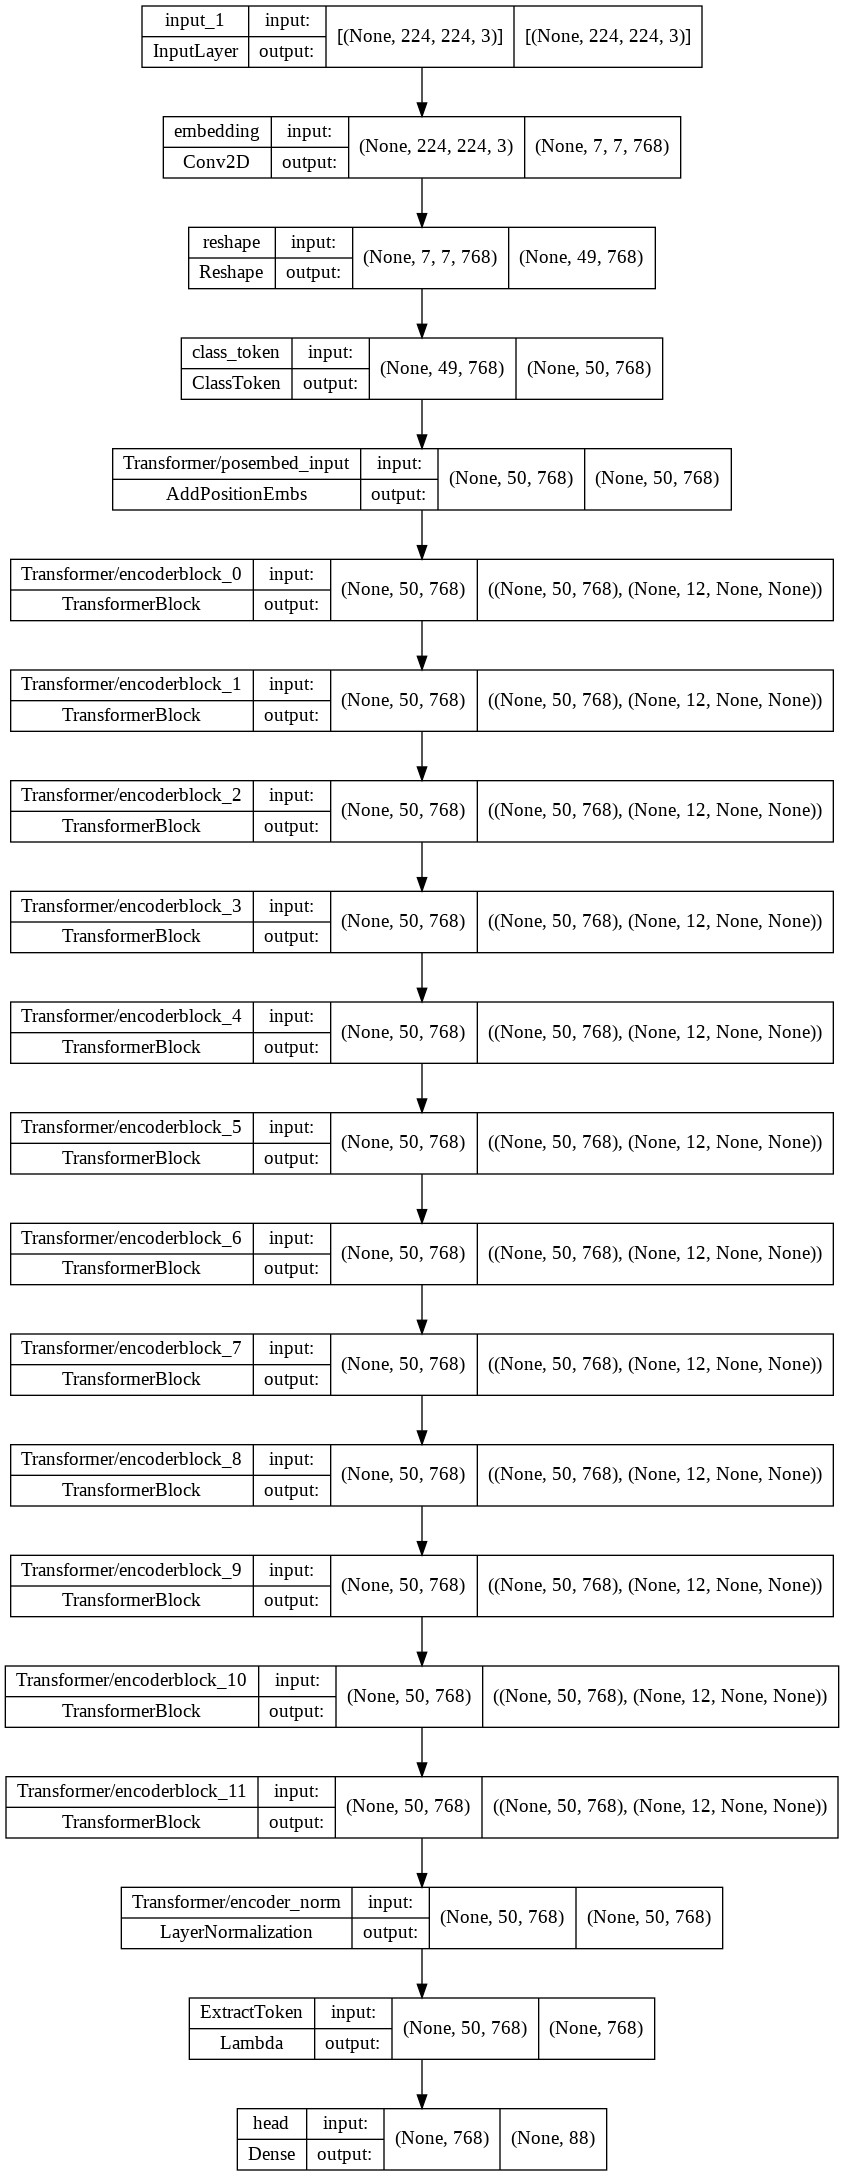

In [ ]:
# model 시각화
plot_model(transformer_model, show_shapes=True)

In [ ]:
for layer in transformer_model.layers[:-1]:
    # 해당 레이어의 weight는 수정하지 않고 이미지넷 대회의 값 그대로 사용 
    layer.trainable = False
    print("layer.name =", layer.name)
    print("layer.trainable = ", layer.trainable)
    print("="*100)

layer.name = input_1
layer.trainable =  False
layer.name = embedding
layer.trainable =  False
layer.name = reshape
layer.trainable =  False
layer.name = class_token
layer.trainable =  False
layer.name = Transformer/posembed_input
layer.trainable =  False
layer.name = Transformer/encoderblock_0
layer.trainable =  False
layer.name = Transformer/encoderblock_1
layer.trainable =  False
layer.name = Transformer/encoderblock_2
layer.trainable =  False
layer.name = Transformer/encoderblock_3
layer.trainable =  False
layer.name = Transformer/encoderblock_4
layer.trainable =  False
layer.name = Transformer/encoderblock_5
layer.trainable =  False
layer.name = Transformer/encoderblock_6
layer.trainable =  False
layer.name = Transformer/encoderblock_7
layer.trainable =  False
layer.name = Transformer/encoderblock_8
layer.trainable =  False
layer.name = Transformer/encoderblock_9
layer.trainable =  False
layer.name = Transformer/encoderblock_10
layer.trainable =  False
layer.name = Transformer/enco

In [ ]:
for layer in transformer_model.layers[-1:]:
    # 해당 레이어의 weight는 수정하지 않고 이미지넷 대회의 값 그대로 사용 
    layer.trainable = True
    print("layer.name =", layer.name)
    print("layer.trainable = ", layer.trainable)
    print("="*100)

layer.name = head
layer.trainable =  True


In [ ]:
# #GradientDecnet를 이용해서 w0,b0와 w1,b1를 찾는 방법을 설정함
# #loss='categorical_crossentropy' : -(y * tf.log(hypothesis1)) 합 이 최소가 되는 w1,w2,w3,w4 를 찾음
# #optimizer=Adam(lr=1e-5) : learning rate를 0.00001 로 설정
# transformer_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-3),metrics=['acc'])

In [ ]:
import tensorflow_addons as tfa

In [ ]:
    transformer_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=[tfa.metrics.F1Score(num_classes=num_classes, average='macro', name='f1')]
    )

In [ ]:
#model.fit(train_generator ,epochs=100) :train_generator 를 이용해서 이미지를 리턴 받음 (epach를 진행할때 마다 증강된 이미지 리턴)
#                                       epochs=300 - 50개씩(batch_size) 3번 150개 이미지를 300번 반복해서 학습
transformer_model.fit(
      train_sequence,
      epochs=200,
      validation_data=test_sequence, # 한번 학습이 끝날때 마다 test_generator(테스트 데이터) 로 검증
      shuffle=True,
      #class_weight = class_weights
      )

Epoch 1/200
193/193 [==============================] - 287s 1s/step - loss: 3.1772 - f1: 0.0708 - val_loss: 1.5392 - val_f1: 0.1352
Epoch 2/200
193/193 [==============================] - 270s 1s/step - loss: 1.5113 - f1: 0.1406 - val_loss: 1.0272 - val_f1: 0.1565
Epoch 3/200
193/193 [==============================] - 271s 1s/step - loss: 1.1744 - f1: 0.1490 - val_loss: 0.9048 - val_f1: 0.1560
Epoch 4/200
193/193 [==============================] - 280s 1s/step - loss: 1.0134 - f1: 0.1529 - val_loss: 0.8196 - val_f1: 0.1560
Epoch 5/200
193/193 [==============================] - 266s 1s/step - loss: 0.9252 - f1: 0.1615 - val_loss: 0.7557 - val_f1: 0.1560
Epoch 6/200
193/193 [==============================] - 283s 1s/step - loss: 0.8856 - f1: 0.1598 - val_loss: 0.7065 - val_f1: 0.1560
Epoch 7/200
193/193 [==============================] - 275s 1s/step - loss: 0.8390 - f1: 0.1691 - val_loss: 0.6803 - val_f1: 0.1560
Epoch 8/200
193/193 [==============================] - 266s 1s/step - loss: 

KeyboardInterrupt: ignored

In [ ]:
#best_model을 이용해 정확도 계산
transformer_model.evaluate(test_sequence)

14/14 [==============================] - 13s 900ms/step - loss: 0.3565 - f1: 0.4156


[0.35649728775024414, 0.4156232178211212]

In [ ]:
predict_list = []
label_list = []
#테스트 이미지와 레이블 리턴
for img,label in test_sequence:
    #이미지를 예측
    predict = transformer_model.predict(img)
    #예측값을 리스트에 추가
    predict_list.extend(predict.tolist())
    #레이블을 리스트에 추가
    label_list.extend(label.tolist())

In [ ]:
#예측값을 배열로 변환
predict_arr = np.array(predict_list)

In [ ]:
predict_arr

array([[5.20081898e-08, 7.07124855e-07, 3.51790618e-06, ..., 3.96253853e-07, 4.69819881e-08, 1.36632707e-06],
       [1.00465643e-11, 2.35222952e-10, 1.32978434e-10, ..., 1.05016126e-11, 1.03638065e-09, 2.95432151e-10],
       [1.81283397e-08, 2.87547823e-06, 4.67499461e-07, ..., 8.65344703e-08, 1.70249645e-08, 1.51300696e-07],
       ...,
       [4.93951802e-07, 5.03474212e-07, 1.25302165e-07, ..., 1.40995988e-08, 2.02332657e-07, 9.82373720e-08],
       [1.43381794e-06, 2.93960369e-07, 5.23845131e-07, ..., 1.07914980e-06, 1.10722976e-05, 2.91695301e-07],
       [5.58897959e-08, 5.76339346e-07, 6.31240664e-06, ..., 5.66081235e-06, 8.52982703e-06, 1.35411228e-05]])

In [ ]:
predict_arr.shape

(428, 88)

In [ ]:
#레이블을 배열로 변환
label_arr = np.array(label_list)

In [ ]:
label_arr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
label_arr.shape

(428, 88)

In [ ]:
#예측값의 최고 값이 저장된 인덱스 리턴
predict01 = np.argmax(predict_arr, axis=1)

In [ ]:
#레이블의 최고 값이 저장된 레이블 리턴
label01 = np.argmax(label_arr, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
#컨퓨전 매트릭스리턴
cm = confusion_matrix(label01 , predict01)

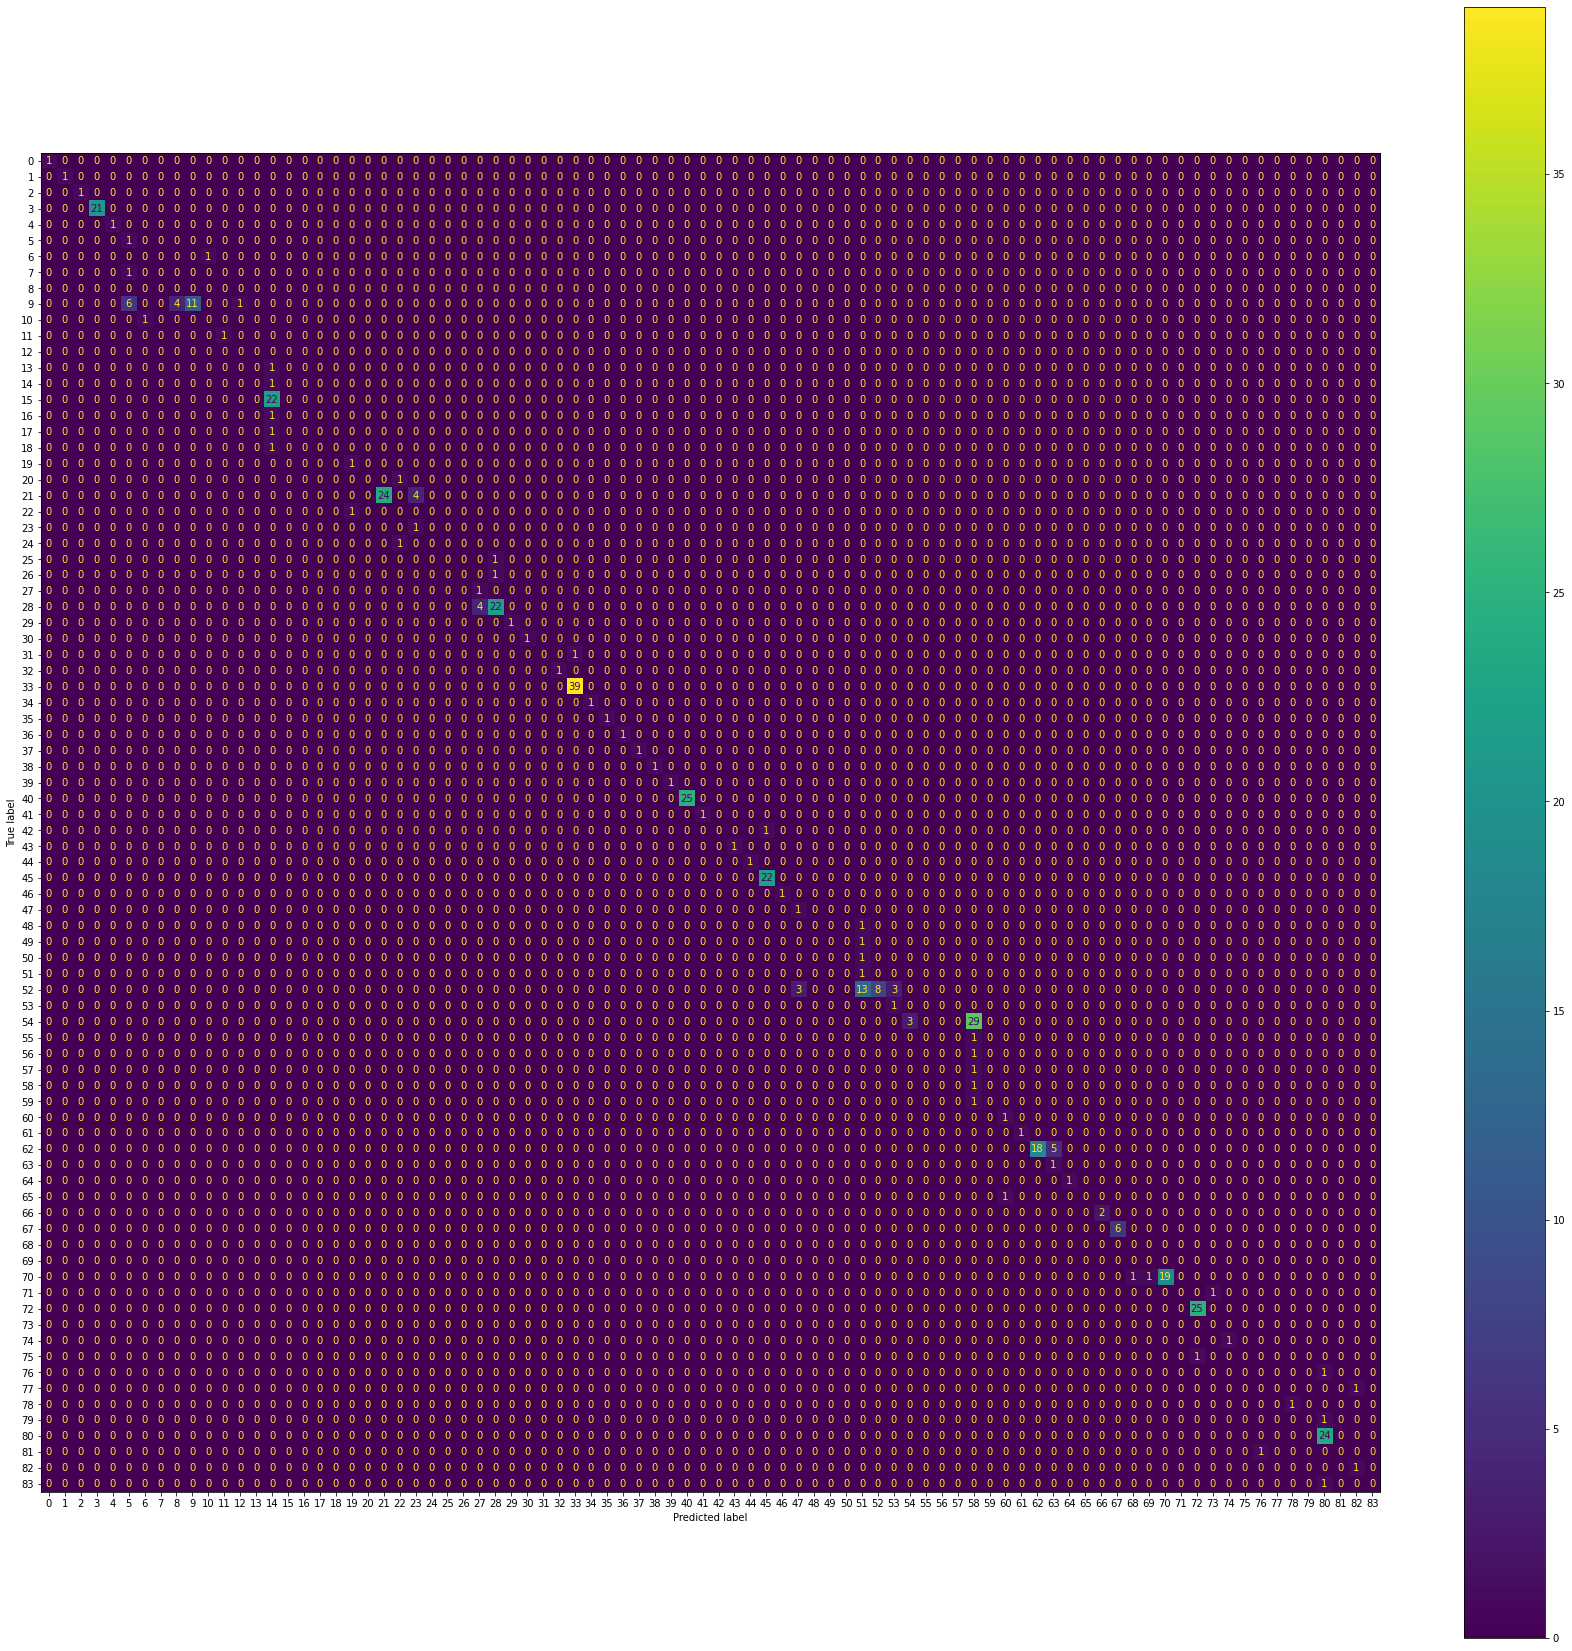

In [ ]:
#컨퓨전 메트릭스 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=np.arange(88))
fig, ax = plt.subplots(figsize=(30,30))
disp.plot(ax=ax)


In [ ]:
#transformer_model.save('/content/drive/MyDrive/project_team_3/vit.h5')